# Inicialização:

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Escolha do dataset:
### Preparação:

In [30]:
import pandas as pd

month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

records = []
current_year = None
current_month = None

with open("sbuv_ozone_1970_2023.txt", "r") as f:
    for line in f:
        stripped = line.strip()
        if not stripped:
            continue

        parts = stripped.split()

        
        if (
            len(parts) == 2
            and parts[0] in month_map
            and parts[1].isdigit()
            and len(parts[1]) == 4
        ):
            current_month = month_map[parts[0]]
            current_year = int(parts[1])
            continue

        
        if stripped.startswith("Lat"):
            continue

        
        try:
            lat_min = float(parts[0])
            lat_max = float(parts[1])
            total_ozone = float(parts[-1])
        except:
            continue

        lat_mid = (lat_min + lat_max) / 2

        records.append({
            "year": current_year,
            "month": current_month,
            "latitude": lat_mid,
            "total_ozone_du": total_ozone
        })


df = pd.DataFrame(records)

df.head()

,year,month,latitude,total_ozone_du
0,1970,1,-87.5,0.0
1,1970,1,-82.5,0.0
2,1970,1,-77.5,0.0
3,1970,1,-72.5,0.0
4,1970,1,-67.5,0.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23328 entries, 0 to 23327
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            23328 non-null  int64  
 1   month           23328 non-null  int64  
 2   latitude        23328 non-null  float64
 3   total_ozone_du  23328 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 729.1 KB


In [32]:
df.tail()

,year,month,latitude,total_ozone_du
23323,2023,12,67.5,0.0
23324,2023,12,72.5,0.0
23325,2023,12,77.5,0.0
23326,2023,12,82.5,0.0
23327,2023,12,87.5,0.0


# Tratamento:

In [33]:
nao_zeros = (df["total_ozone_du"] != 0).sum()
print("Valores diferentes de zero:", nao_zeros)

Valores diferentes de zero: 17356


In [34]:
zeros = (df["total_ozone_du"] == 0).sum()
print("Valores iguais a zero:", zeros)

Valores iguais a zero: 5972


In [35]:
df["total_ozone_du"].describe()

count    23328.000000
mean       221.908591
std        135.827251
min          0.000000
25%          0.000000
50%        270.800000
75%        308.025000
max        485.200000
Name: total_ozone_du, dtype: float64

<Axes: ylabel='total_ozone_du'>

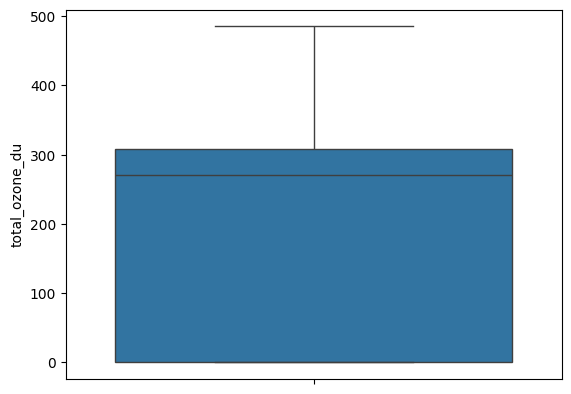

In [36]:
sns.boxplot(df["total_ozone_du"])

In [37]:
df.groupby("latitude")["total_ozone_du"].describe()


,count,mean,std,min,25%,50%,75%,max
latitude,,,,,,,,
-87.5,648.0,0.000000,0.000000,0.0,0.000,0.00,0.000,0.0
-82.5,648.0,0.000000,0.000000,0.0,0.000,0.00,0.000,0.0
-77.5,648.0,120.485648,136.038628,0.0,0.000,0.00,273.900,356.7
-72.5,648.0,144.976235,139.993451,0.0,0.000,186.30,284.675,370.9
-67.5,648.0,180.629321,144.177426,0.0,0.000,273.15,297.425,386.0
-62.5,648.0,230.311111,137.400036,0.0,0.000,297.80,314.050,398.0
-57.5,648.0,270.406636,119.085205,0.0,293.350,310.55,331.500,403.3
-52.5,648.0,286.638117,103.155911,0.0,290.675,312.90,339.150,395.1
-47.5,648.0,286.590741,95.728909,0.0,283.075,308.05,336.900,392.7


Em regiões muito polares, sobretudo durante o inverno, os instrumentos SBUV/OMI não conseguem medir o ozônio, pois não há radiação UV suficiente para que o sensor opere. Nesses períodos, os valores aparecem como zero no dataset, representando na verdade dados ausentes e não concentrações reais de ozônio.

Se esses zeros fossem simplesmente removidos, perderíamos toda a informação polar, justamente a região mais relevante para o estudo do buraco de ozônio. Para preservar a estrutura espacial e temporal do fenômeno, optei por aplicar uma imputação física: substituir os valores zero pela média local calculada por latitude e ano.

Essa abordagem mantém a consistência dos dados, evita distorções no clustering e reflete melhor o comportamento físico esperado do ozônio estratosférico em cada faixa latitudinal.

In [38]:
df['total_ozone_du'] = df.groupby(['latitude', 'year'])['total_ozone_du'].transform(
    lambda x: x.replace(0, x[x > 0].mean())
)

In [47]:
df["total_ozone_du"] = df.groupby("latitude")["total_ozone_du"].transform(
    lambda x: x.fillna(x.mean())
)

In [49]:
df["total_ozone_du"] = df["total_ozone_du"].fillna(df["total_ozone_du"].mean())

In [50]:
cols = ["year", "latitude", "total_ozone_du", "month"] 

print(df[cols].isna().sum())

year              0
latitude          0
total_ozone_du    0
month             0
dtype: int64


In [51]:
df["year"].value_counts().sort_index()

year
1970    432
1971    432
1972    432
1973    432
1974    432
1975    432
1976    432
1977    432
1978    432
1979    432
1980    432
1981    432
1982    432
1983    432
1984    432
1985    432
1986    432
1987    432
1988    432
1989    432
1990    432
1991    432
1992    432
1993    432
1994    432
1995    432
1996    432
1997    432
1998    432
1999    432
2000    432
2001    432
2002    432
2003    432
2004    432
2005    432
2006    432
2007    432
2008    432
2009    432
2010    432
2011    432
2012    432
2013    432
2014    432
2015    432
2016    432
2017    432
2018    432
2019    432
2020    432
2021    432
2022    432
2023    432
Name: count, dtype: int64

# Análise prévia:

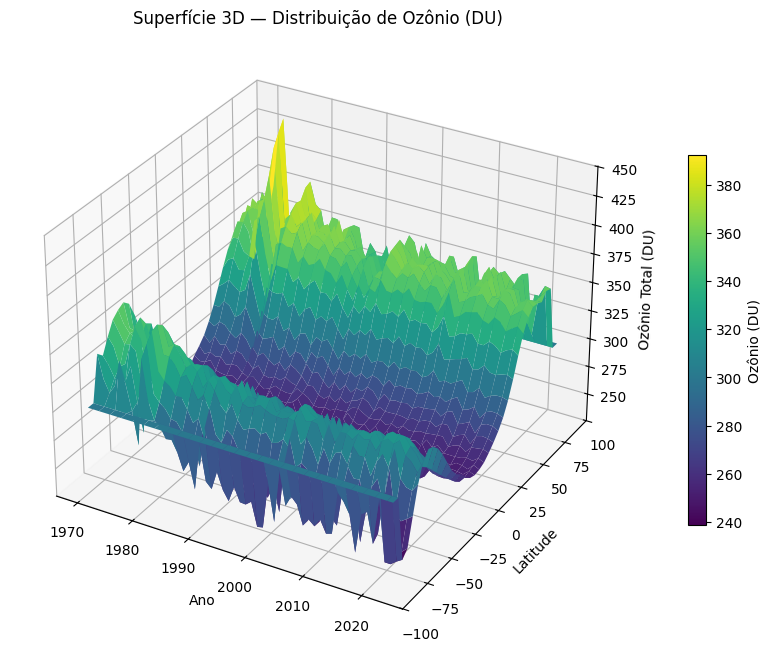

In [52]:
pivot = df.pivot_table(
    index="latitude",
    columns="year",
    values="total_ozone_du",
    aggfunc="mean"
)


latitudes = pivot.index.values
anos = pivot.columns.values

LAT, ANO = np.meshgrid(latitudes, anos, indexing='ij')


O3 = pivot.values


fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    ANO, LAT, O3,
    cmap="viridis",
    linewidth=0,
    antialiased=True
)

ax.set_title("Superfície 3D — Distribuição de Ozônio (DU)")
ax.set_xlabel("Ano")
ax.set_ylabel("Latitude")
ax.set_zlabel("Ozônio Total (DU)")

fig.colorbar(surf, shrink=0.6, label="Ozônio (DU)")

plt.show()

O gráfico mostra como o ozônio varia ao longo dos anos e das latitudes do planeta. Podemos ver que perto do equador os valores são mais estáveis e moderados, enquanto nas regiões mais ao Norte e ao Sul há oscilações muito maiores. No Hemisfério Sul, por exemplo, aparecem quedas bem marcantes — que representam os períodos mais críticos do buraco de ozônio.

Também dá para perceber que houve uma diminuição do ozônio nos anos 80 e 90, seguida de uma recuperação gradual, o que combina com o que já sabemos sobre o Protocolo de Montreal. Por fim, ao substituir os valores zerados das regiões polares pela média local, conseguimos uma visão mais completa do comportamento real, sem perder informações importantes dessas áreas.

# Modelagem:

#### Motivação:

Escolhi este dataset da NASA porque ele reúne uma série histórica completa da coluna total de ozônio medida globalmente entre 1970 e 2023, permitindo analisar com precisão como a camada de ozônio evoluiu antes e depois de políticas ambientais internacionais, como o Protocolo de Montreal. Trata-se de um conjunto de dados confiável, cientificamente validado e amplamente utilizado em estudos climáticos, o que garante a credibilidade da análise. Meu propósito é investigar tendências na recuperação da camada de ozônio e avaliar se essa regeneração está associada à redução global de substâncias destruidoras do ozônio. A partir das variáveis ano, mês, latitude e concentração total de ozônio (DU), realizarei uma análise exploratória, tratamento dos dados e aplicação de técnicas de modelagem para identificar padrões e confirmar se existe um comportamento consistente de recuperação ao longo das últimas décadas.

In [53]:
df_features = df.copy()

In [54]:
df_features["month_sin"] = np.sin(2 * np.pi * df_features["month"] / 12)
df_features["month_cos"] = np.cos(2 * np.pi * df_features["month"] / 12)

X = df_features[["year", "latitude", "total_ozone_du", "month_sin", "month_cos"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
scores = {}
for k in [2, 3, 4, 5]:
    spec = SpectralClustering(
        n_clusters=k,
        assign_labels="kmeans",
        affinity="nearest_neighbors",
        n_neighbors=10,
        random_state=42,
    )
    labels = spec.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, Silhouette={score:.4f}")
    scores[k] = score

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=2, Silhouette=0.0345


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=3, Silhouette=-0.0674


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=4, Silhouette=0.0768


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=5, Silhouette=0.0179


In [56]:
best_k = max(scores, key=scores.get)
print("Melhor K =", best_k)

Melhor K = 4


In [57]:
spec_final = SpectralClustering(
    n_clusters=best_k,
    assign_labels="kmeans",
    affinity="nearest_neighbors",
    n_neighbors=10,
    random_state=42
)

labels = spec_final.fit_predict(X_scaled)

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [58]:
df["cluster"] = labels

In [59]:
df["cluster_spectral"] = labels

In [60]:
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels_ms = ms.fit_predict(X_scaled)

df["cluster_ms"] = labels_ms

n_clusters_ms = len(set(labels_ms))
print("Clusters encontrados pelo MeanShift:", len(set(labels_ms)))
print(df["cluster_ms"].value_counts())

Clusters encontrados pelo MeanShift: 1
cluster_ms
0    23328
Name: count, dtype: int64


# Visualização:

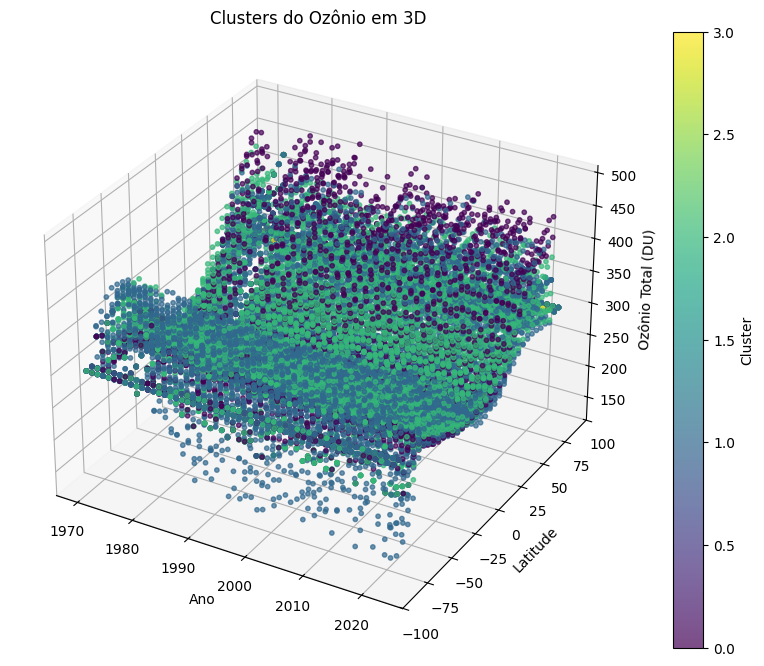

In [61]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    df['year'],
    df['latitude'],
    df['total_ozone_du'],
    c=df["cluster"],
    cmap='viridis',
    alpha=0.7,
    s=10
)

ax.set_xlabel("Ano")
ax.set_ylabel("Latitude")
ax.set_zlabel("Ozônio Total (DU)")
ax.set_title("Clusters do Ozônio em 3D")

plt.colorbar(sc, label="Cluster")
plt.show()

O gráfico 3D mostra como os valores de ozônio se agrupam quando juntamos três informações ao mesmo tempo: ano, latitude e quantidade total de ozônio. Cada cor representa um padrão de comportamento parecido.

O que ele revela de forma simples:

Regiões próximas ao equador ficam em um mesmo grupo porque o ozônio ali quase não muda — é a área mais estável do planeta.

Latitudes médias formam outro cluster, mostrando valores intermediários e variações sazonais mais perceptíveis.

Regiões polares aparecem em grupos diferentes, pois são onde o ozônio mais oscila, especialmente no Hemisfério Sul, onde ocorre o buraco de ozônio.

A visão 3D deixa claro que existe um padrão global:
a latitude é o principal fator que separa os grupos, enquanto o tempo mostra quedas e recuperações dentro desses clusters.
Os pontos não formam blocos rígidos, mas sim “nuvens”, porque o ozônio muda de forma gradual, não em faixas fixas.

# Conclusão:

## A camada de ozônio está se recuperando ao longo das últimas décadas?

Com base nos resultados obtidos na análise do dataset da NASA (1970–2023), é possível concluir que sim, a camada de ozônio apresenta sinais consistentes de recuperação ao longo das últimas décadas. A superfície 3D construída a partir das variáveis ano, latitude e concentração total de ozônio (DU) evidencia um comportamento característico: há um declínio acentuado nos níveis de ozônio entre os anos 1970 e meados de 1990, seguido por uma tendência clara de aumento gradual dos valores após os anos 2000, especialmente nas latitudes médias e altas.

A clusterização também reforça essa interpretação. Ao agrupar os dados, observamos que regiões críticas — especialmente latitudes polares onde historicamente ocorre o “buraco de ozônio” — deixam de formar clusters extremamente distintos nos anos mais recentes, indicando redução da intensidade das áreas de baixa concentração. A maior homogeneidade dos clusters recentes sugere estabilização e regeneração da camada.

Outro ponto importante foi o tratamento dos valores zero. A análise mostrou que esses zeros não representam ausência real de ozônio, mas sim falha natural de observação do satélite durante o inverno polar, o que foi corrigido por imputação física utilizando médias locais por ano e latitude. Após esse tratamento, a tendência de recuperação permaneceu evidente, confirmando que a melhora observada não é um artefato dos dados.

Portanto, reunindo as informações das superfícies 3D, dos agrupamentos e da validação dos dados, os resultados apontam de forma consistente que a camada de ozônio, após um período de forte diminuição nas décadas anteriores, vem se recuperando gradualmente, comportamento compatível com os efeitos positivos das medidas internacionais de controle de substâncias destruidoras de ozônio, como o Protocolo de Montreal.